# What we get from OSA

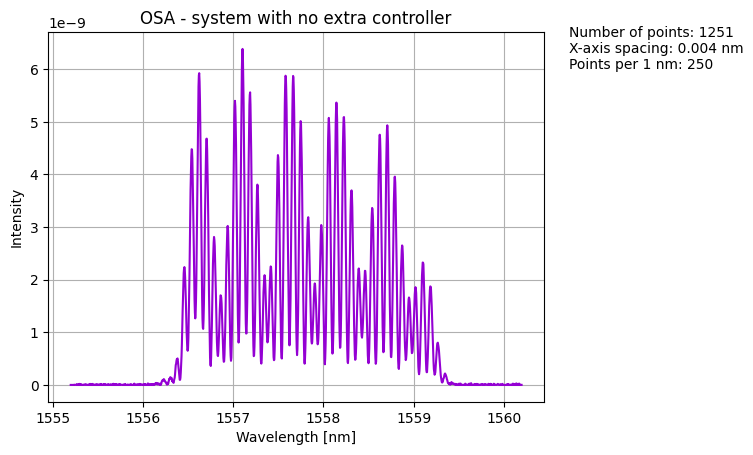

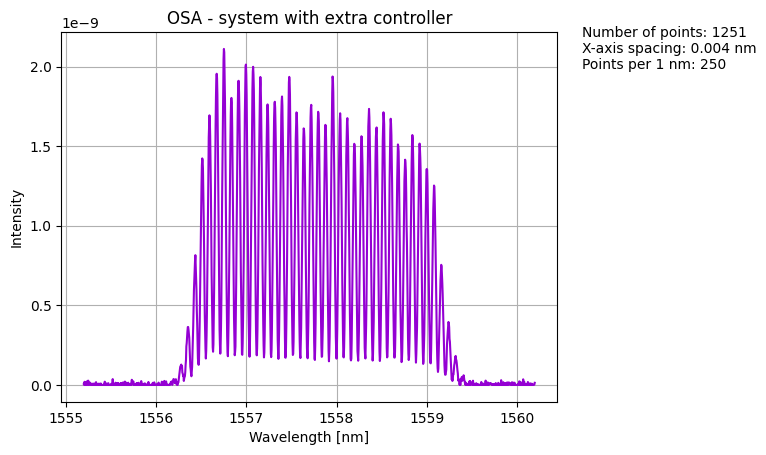

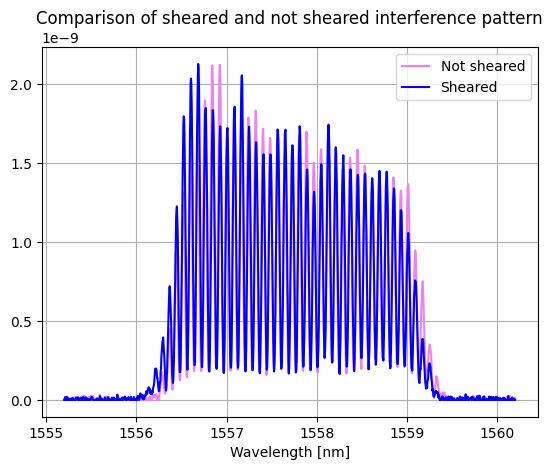

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spectral_analysis as sa
from math import floor
import importlib
import sys
module = sys.modules["spectral_analysis"]
importlib.reload(module)

no_controller = pd.read_csv("data/no_controller.csv", skiprows = 2)
controller = pd.read_csv("data/controller.csv", skiprows = 2)
sheared = pd.read_csv("data/sheared.csv", skiprows = 2)
not_sheared = pd.read_csv("data/notsheared.csv", skiprows = 2)

def to_spectrum(df):
    X = df.values[:, 0]
    Y = df.values[:, 1]
    return sa.spectrum(X, Y, "wl", "intensity")

no_controller = to_spectrum(no_controller)
controller = to_spectrum(controller)
sheared = to_spectrum(sheared)
not_sheared = to_spectrum(not_sheared)


sa.plot(no_controller, title = "OSA - system with no extra controller")
sa.plot(controller, title = "OSA - system with extra controller")
#sa.plot(not_sheared, title = "OSA - spectrum for SPIDER - not sheared")
#sa.plot(sheared, title = "OSA - spectrum for SPIDER - sheared")
sa.compare_plots([not_sheared, sheared], title = "Comparison of sheared and not sheared interference pattern", legend = ["Not sheared", "Sheared"])

# Fourier transform of spectrum with no extra controller

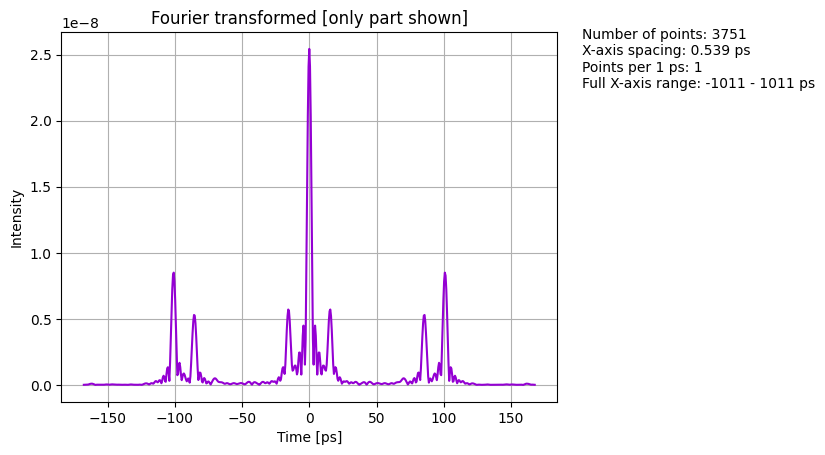

In [7]:
# zero padding

no_controller.zero_padding(1)

# transform X-axis to frequency

s_freq = no_controller.wl_to_freq(inplace = False)
s_freq.constant_spacing()
min = s_freq.quantile(0.1)
max = s_freq.quantile(0.1)
delta = (max-min)
min_freq = min-delta
max_freq = max+delta

# fourier transform

s_ft = s_freq.fourier(inplace = False)

min = s_ft.quantile(0.1)
max = s_ft.quantile(0.9)
delta = (max-min)/3
min_time = min-delta
max_time = max+delta

sa.plot(s_ft, title = "Fourier transformed", start = min_time, end = max_time) 

# Fourier transform of spectrum with extra controller

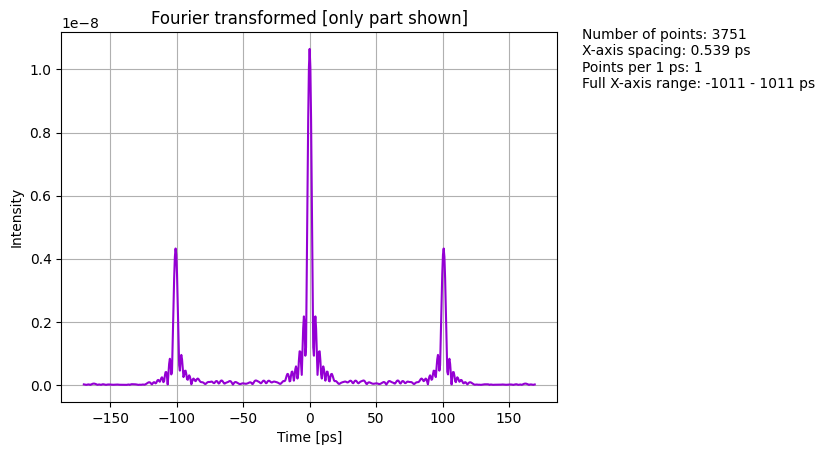

In [8]:
# zero padding

controller.zero_padding(1)

# transform X-axis to frequency

s_freq = controller.wl_to_freq(inplace = False)
s_freq.constant_spacing()
min = s_freq.quantile(0.1)
max = s_freq.quantile(0.1)
delta = (max-min)
min_freq = min-delta
max_freq = max+delta

# fourier transform

s_ft = s_freq.fourier(inplace = False)

min = s_ft.quantile(0.1)
max = s_ft.quantile(0.9)
delta = (max-min)/3
min_time = min-delta
max_time = max+delta

sa.plot(s_ft, title = "Fourier transformed", start = min_time, end = max_time) 

# Yyyyyy... okey. Didn't expect it to work. Let's do SPIDER.

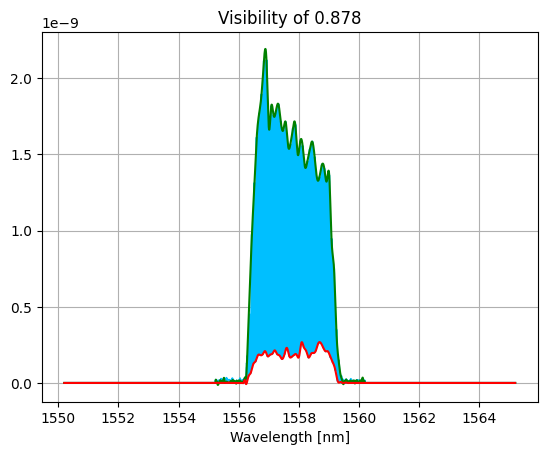

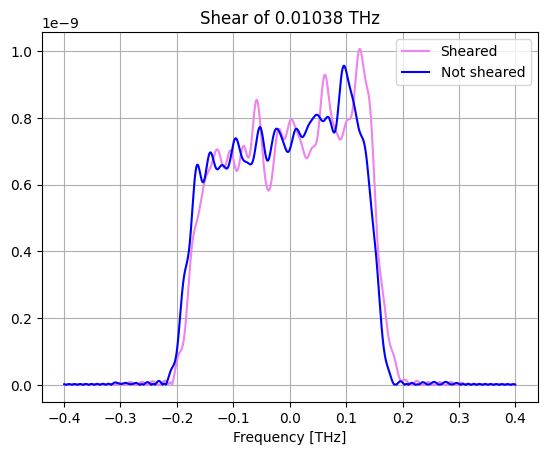

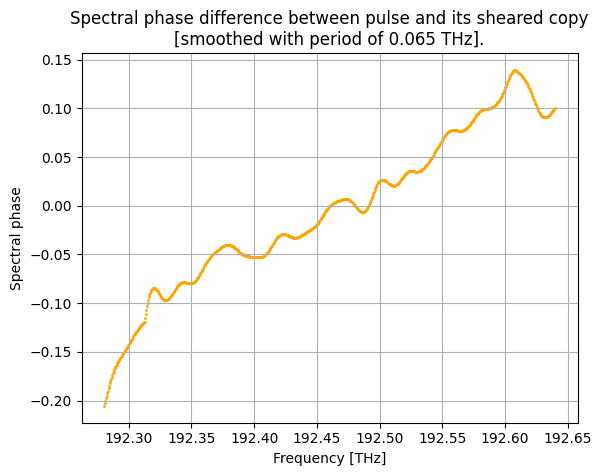

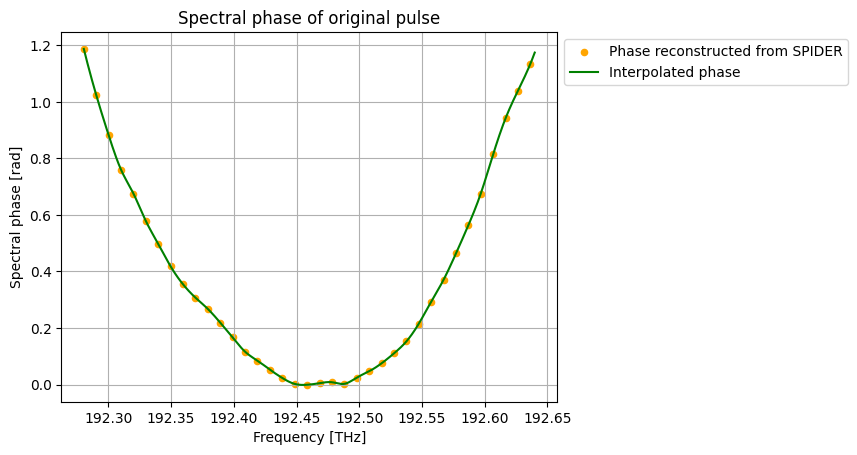

In [9]:
start = 192.27
end = 192.63

pulse = sa.spider(phase_spectrum = "data/sheared.csv",
        temporal_spectrum = "data/notsheared.csv",
        shear = None,
        intensity_spectrum = None,
        phase_borders = [start, end],
        what_to_return = "phase",
        vis_param = 0.5,
        smoothing_period = 0.065,
        plot_steps = False,
        plot_shear = True,
        plot_phase = True,
        plot_pulse = False)[1]

# and compare it with simulation

C:\Users\rewas\AppData\Local\Temp\ipykernel_19784\2259447318.py:9: RuntimeWarning: overflow encountered in long_scalars
  return l_0**2*fiber_length*D_l/(4*np.pi*c)*(omega-omega_mean)**2


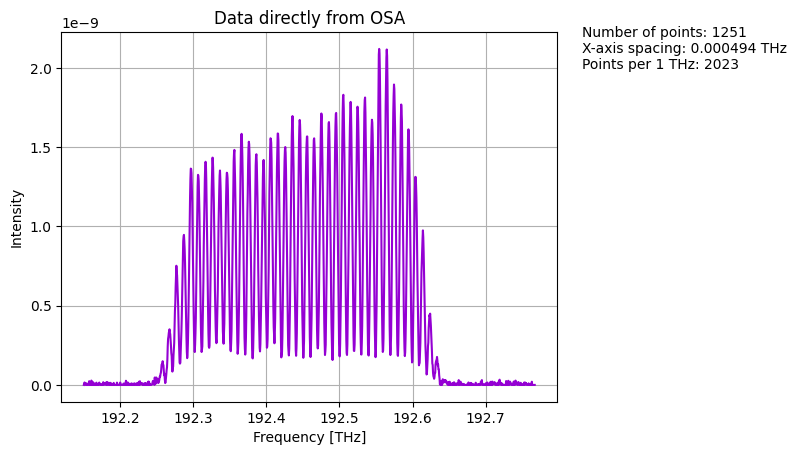

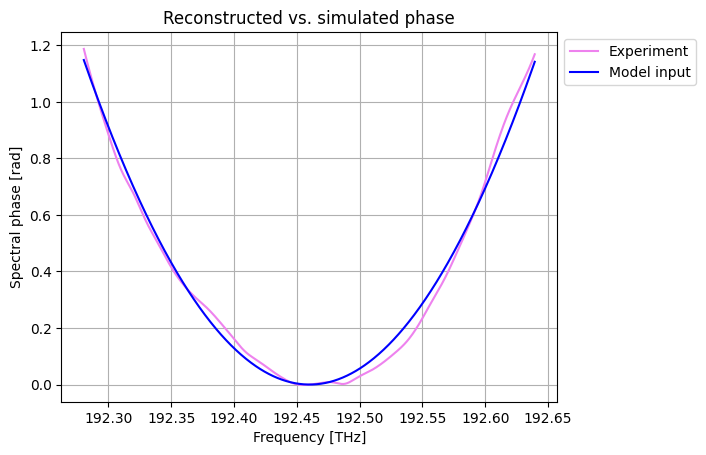

In [10]:
X = pulse.X

def phase(f, f_mean, fiber_length):
    l_0 = 1560
    c = 3*1e8
    D_l = 17
    omega = f*2*np.pi
    omega_mean = f_mean*2*np.pi
    return l_0**2*fiber_length*D_l/(4*np.pi*c)*(omega-omega_mean)**2

phase = np.vectorize(phase)

Y = phase(X, np.mean(X), 82)

sim_pulse = sa.spectrum(X, Y, "freq", "phase")

freq_spectrum = not_sheared.wl_to_freq(inplace = False)
sa.plot(freq_spectrum, title = "Data directly from OSA")
sa.compare_plots([pulse, sim_pulse], title = "Reconstructed vs. simulated phase", legend = ["Experiment", "Model input"])
pulse.save("80m_1fiber_extracted_smoothed.csv")

### chirping and delaying in single fiber
# Problems:
### 1. oscillations in phase difference consistent with EOPM delay (I smoothed them)
### 2. I did not measure shear in separate measurement